In [1]:
import numpy as np
from scipy import stats
from scipy.interpolate import griddata

import einops
import concurrent.futures
import pickle


import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import niapy
from niapy.problems import Alpine1 as TestFunction

import hiposa
from hiposa.poisson_disc_sampling import PoissonDiskSamplerWithExisting

import os

In [2]:
def compute_masked_similarity(heatmap1, heatmap2, percentile=5, method='f1'):
    """
    Compute similarity metrics between two heatmaps after masking values below a specified percentile.
    
    Parameters:
    -----------
    heatmap1 : 2D numpy array
        First heatmap data, may contain NaNs
    heatmap2 : 2D numpy array
        Second heatmap data, may contain NaNs
    percentile : float, optional
        The percentile threshold to create masks (default: 5)
        Values below this percentile will be masked out
    method : str, optional
        Similarity method: 'f1', 'correlation', 'jaccard', or 'all' (default: 'f1')
        
    Returns:
    --------
    dict : A dictionary containing:
        - 'f1_score': F1 score between the masks (if method is 'f1' or 'all')
        - 'precision': Precision between the masks (if method is 'f1' or 'all')
        - 'recall': Recall between the masks (if method is 'f1' or 'all')
        - 'correlation': Correlation coefficient between masks (if method is 'correlation' or 'all')
        - 'p_value': P-value of the correlation (if method is 'correlation' or 'all')
        - 'jaccard': Jaccard similarity index (if method is 'jaccard' or 'all')
        - 'overlap_count': Number of overlapping non-NaN points after masking
        - 'mask1': Boolean mask for heatmap1 (True for values above threshold)
        - 'mask2': Boolean mask for heatmap2 (True for values above threshold)
        - 'threshold1': The percentile threshold value for heatmap1
        - 'threshold2': The percentile threshold value for heatmap2
    """
    # Handle invalid inputs
    if heatmap1.shape != heatmap2.shape:
        raise ValueError("Heatmaps must have the same shape")
    
    if not (0 <= percentile <= 100):
        raise ValueError("Percentile must be between 0 and 100")
    
    # Compute percentile thresholds, ignoring NaNs
    threshold1 = np.nanpercentile(heatmap1, percentile)
    threshold2 = np.nanpercentile(heatmap2, percentile)
    
    # Create masks (True where values are above threshold)
    mask1 = heatmap1 > threshold1
    mask2 = heatmap2 > threshold2
    
    # Create a common mask where both heatmaps have valid (non-NaN) values
    valid_mask = ~np.isnan(heatmap1) & ~np.isnan(heatmap2)
    
    # Combine with the percentile masks
    combined_mask1 = mask1 & valid_mask
    combined_mask2 = mask2 & valid_mask
    
    # Extract the masked values from both heatmaps
    values1 = heatmap1[valid_mask]
    values2 = heatmap2[valid_mask]
    
    # Create boolean arrays for correlation analysis (using the common valid points)
    bool_array1 = mask1[valid_mask]
    bool_array2 = mask2[valid_mask]
    
    # Count the overlap points (where both masks are True)
    overlap_count = np.sum(bool_array1 & bool_array2)
    total_valid = np.sum(valid_mask)
    
    # Confusion matrix elements
    true_positive = np.sum(bool_array1 & bool_array2)
    false_positive = np.sum(~bool_array1 & bool_array2)
    false_negative = np.sum(bool_array1 & ~bool_array2)
    true_negative = np.sum(~bool_array1 & ~bool_array2)
    
    # Calculate standard F1 score metrics
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate class-specific metrics for macro F1
    # Class 1 (positive class)
    precision_pos = precision  # Already calculated above
    recall_pos = recall  # Already calculated above
    f1_pos = f1  # Already calculated above
    
    # Class 0 (negative class)
    precision_neg = true_negative / (true_negative + false_negative) if (true_negative + false_negative) > 0 else 0
    recall_neg = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0
    f1_neg = 2 * precision_neg * recall_neg / (precision_neg + recall_neg) if (precision_neg + recall_neg) > 0 else 0
    
    # Macro F1 (unweighted average of class F1 scores)
    macro_f1 = (f1_pos + f1_neg) / 2
    
    # Macro precision and recall
    macro_precision = (precision_pos + precision_neg) / 2
    macro_recall = (recall_pos + recall_neg) / 2
    
    # Micro F1 (calculated from summed confusion matrix)
    micro_precision = (true_positive + true_negative) / (true_positive + false_positive + true_negative + false_negative) if (true_positive + false_positive + true_negative + false_negative) > 0 else 0
    micro_recall = (true_positive + true_negative) / (true_positive + false_negative + true_negative + false_positive) if (true_positive + false_negative + true_negative + false_positive) > 0 else 0
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0
    
    # Balanced accuracy (average of recall for each class)
    balanced_accuracy = (recall_pos + recall_neg) / 2
    
    # Matthews correlation coefficient (robust to imbalance)
    mcc_numerator = true_positive * true_negative - false_positive * false_negative
    mcc_denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * 
                             (true_negative + false_positive) * (true_negative + false_negative))
    mcc = mcc_numerator / mcc_denominator if mcc_denominator > 0 else 0
    
    # Calculate Jaccard similarity (intersection over union)
    jaccard = true_positive / (true_positive + false_positive + false_negative) if (true_positive + false_positive + false_negative) > 0 else 0
    
    # Calculate correlation
    corr, p_value = stats.pearsonr(bool_array1.astype(float), bool_array2.astype(float))
    
    # Prepare results dictionary
    results = {
        # Standard metrics
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        
        # Class-balanced metrics
        'macro_f1': macro_f1,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'micro_f1': micro_f1,
        'micro_precision': micro_precision,
        'micro_recall': micro_recall,
        'balanced_accuracy': balanced_accuracy,
        'matthews_correlation': mcc,
        
        # Other metrics
        'jaccard': jaccard,
        'correlation': corr,
        'p_value': p_value,
        
        # Confusion matrix data
        'confusion_matrix': {
            'true_positive': true_positive,
            'false_positive': false_positive,
            'false_negative': false_negative,
            'true_negative': true_negative,
            'class_balance': {
                'positive_ratio': (true_positive + false_negative) / total_valid if total_valid > 0 else 0,
                'negative_ratio': (true_negative + false_positive) / total_valid if total_valid > 0 else 0
            }
        },
        
        # Original data
        'overlap_count': overlap_count,
        'total_valid_points': total_valid,
        'overlap_percentage': 100 * overlap_count / total_valid if total_valid > 0 else 0,
        'mask1': mask1,
        'mask2': mask2,
        'threshold1': threshold1,
        'threshold2': threshold2
    }
    
    return results



In [3]:
def rotate(point, lim=10):
    """
    Rotate a point by 90 degrees (counterclockwise) within a domain of [-lim, lim] x [-lim, lim]
    with periodic boundary conditions.
    
    Parameters:
    point (array-like): [x, y] coordinates of the point to rotate
    lim (float): The limit of the periodic domain [-lim, lim] x [-lim, lim]
    
    Returns:
    numpy.ndarray: The rotated point coordinates, mapped back to the domain
    """
    x, y = point
    
    # Apply 90° counterclockwise rotation
    new_x = y
    new_y = -x
    
    # Map back to [-lim, lim] domain using periodic boundaries
    new_x = ((new_x + lim) % (2*lim)) - lim
    new_y = ((new_y + lim) % (2*lim)) - lim
    return np.array([new_x, new_y])

In [4]:
lower=-10
upper=10
f = TestFunction(dimension=2, upper=upper, lower=lower)

In [5]:
Ngrid = 100j
grid_x, grid_y = np.mgrid[lower:upper:Ngrid,lower:upper:Ngrid,]
f_gt = np.zeros_like(grid_x)
for i in range(100):
    for j in range(100):
        f_gt[i,j]=f( np.array((grid_y[i,j], grid_x[i,j])).flatten() )
        

In [11]:
def generate_poisson_points(i, lower, upper, scale):
    print(lower, upper)
    # Each worker function gets its own seed based on the iteration
    np.random.seed(42 + i)  # Optional but ensures reproducibility with different seeds
    obj = PoissonDiskSamplerWithExisting(domain=[(lower,upper),(lower,upper)], 
                                         r=scale, symmetry_operators=[rotate])
    xy, levels = obj.sample()
    print(f"Worker {i}: Generated {len(xy)} points")
    return (xy, levels)

scales = 0.75
n_sets = 50

# Parallel execution using ThreadPoolExecutor
xyls = []
with concurrent.futures.ThreadPoolExecutor(max_workers=min(n_sets, 32)) as executor:
    # Submit all tasks
    futures = [executor.submit(generate_poisson_points, i, lower, upper, scales) 
               for i in range(n_sets)]
    
    # Collect results as they complete
    for future in concurrent.futures.as_completed(futures):
        xyls.append(future.result())

# Print total points generated
total_points = sum(len(xy) for xy, _ in xyls)
print(f"Total points generated: {total_points}")

-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
-10 10
Worker 28: Generated 473 points
-10 10
Worker 26: Generated 473 points
-10 10
Worker 11: Generated 471 points
-10 10
Worker 24: Generated 485 points
-10 10
Worker 10: Generated 477 points
-10 10
Worker 4: Generated 497 points
-10 10
Worker 0: Generated 485 points
-10 10
Worker 27: Generated 477 points
-10 10
Worker 3: Generated 466 points
-10 10
Worker 2: Generated 489 points
-10 10
Worker 21: Generated 485 points
-10 10
Worker 29: Generated 489 points
-10 10
Worker 19: Generated 485 points
-10 10
Worker 16: Generated 485 points
-10 10
Worker 25: Generated 489 points
-10 10
Worker 12: Generated 481 points
-10 10
Worker 13: Generated 482 points
-10 10
Worker 17: Generated 485 points
-10 10
Worker 1: Generated 489 points
Worker 22: Generated 497 points
Worker 15: Gene

In [12]:
import pickle
pickle.dump(xyls, open("designs-alpline-symmetry-2.pickle", "wb") )

Single Instance


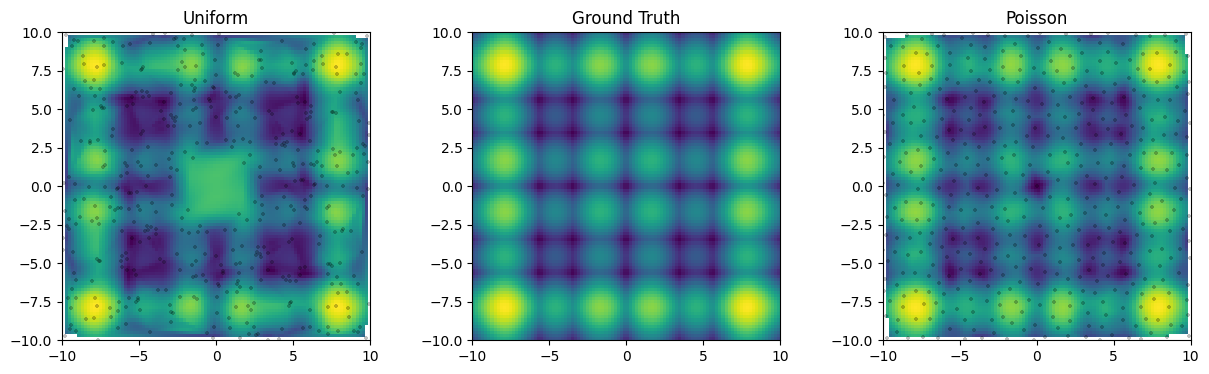

Single Instance


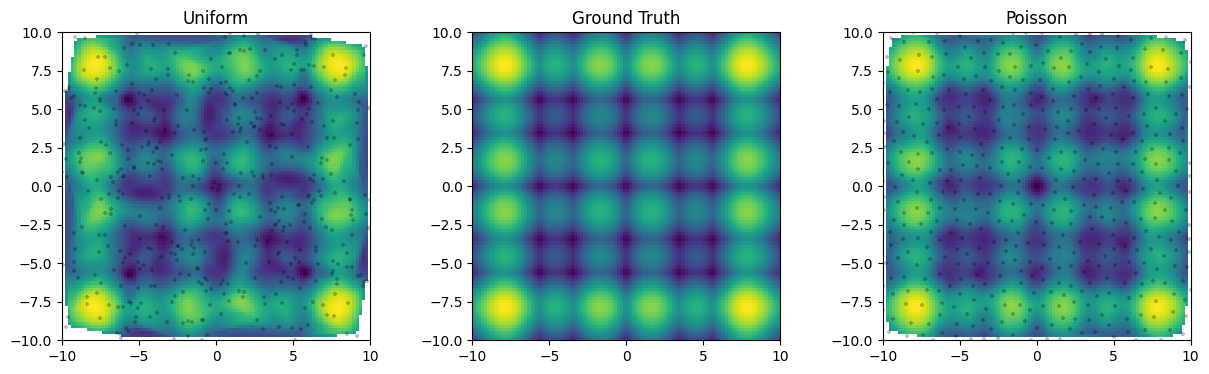

Single Instance


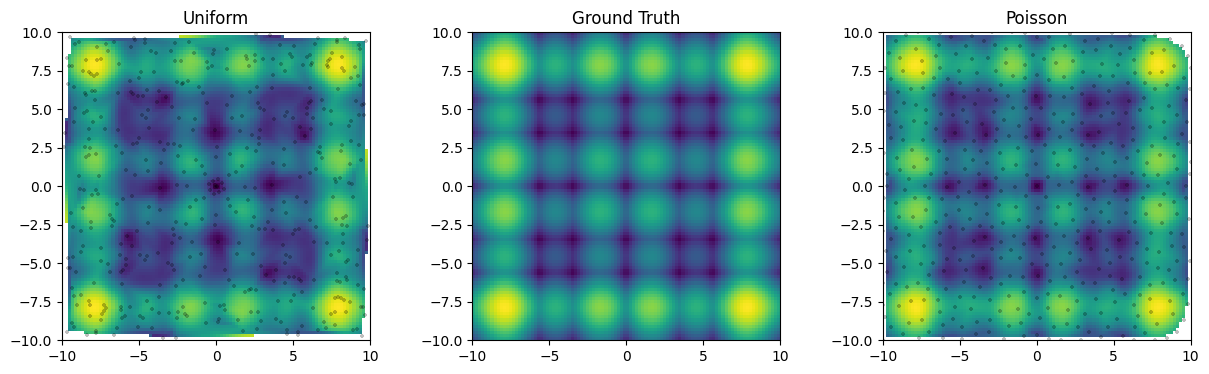

Single Instance


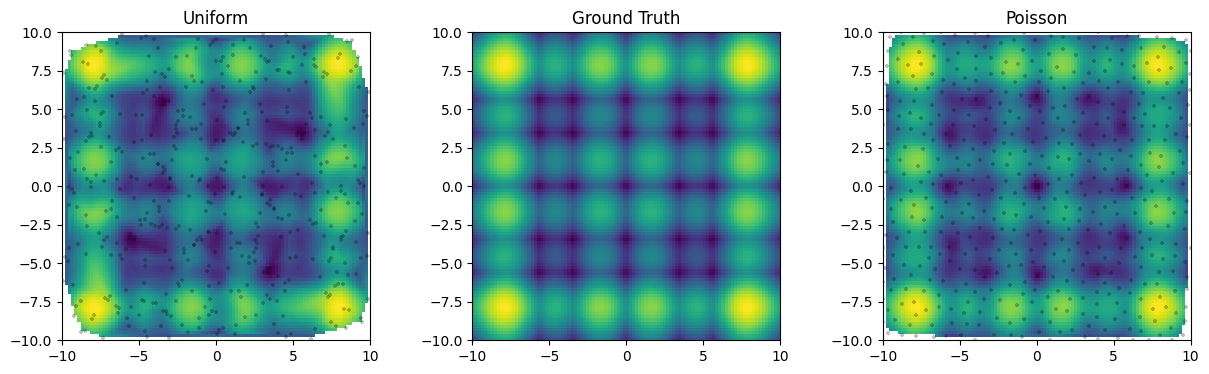

Single Instance


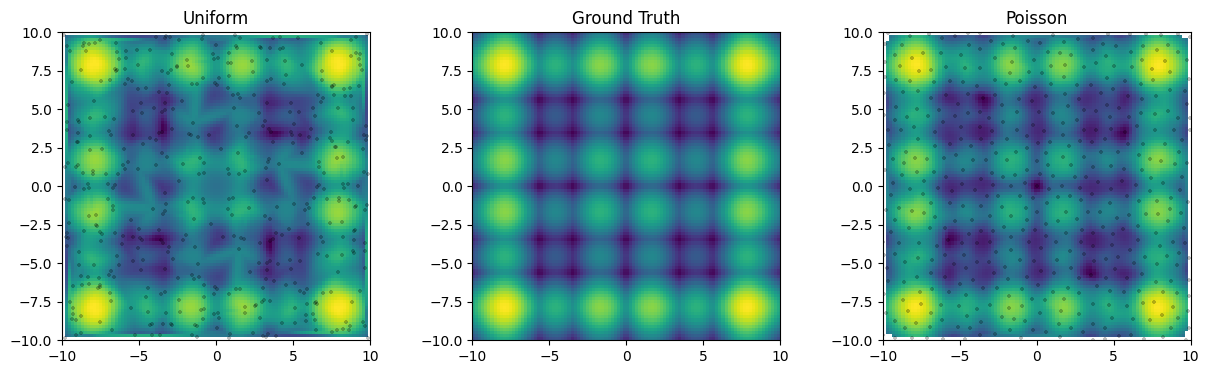

Single Instance


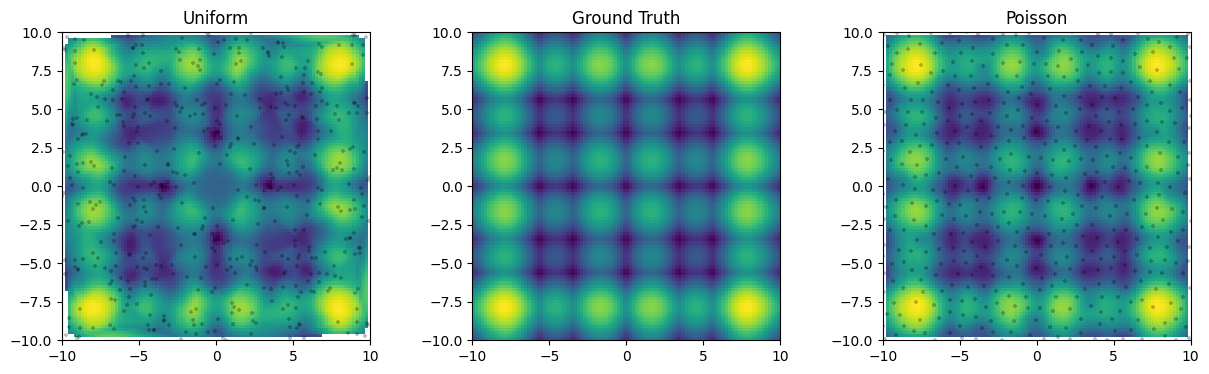

Single Instance


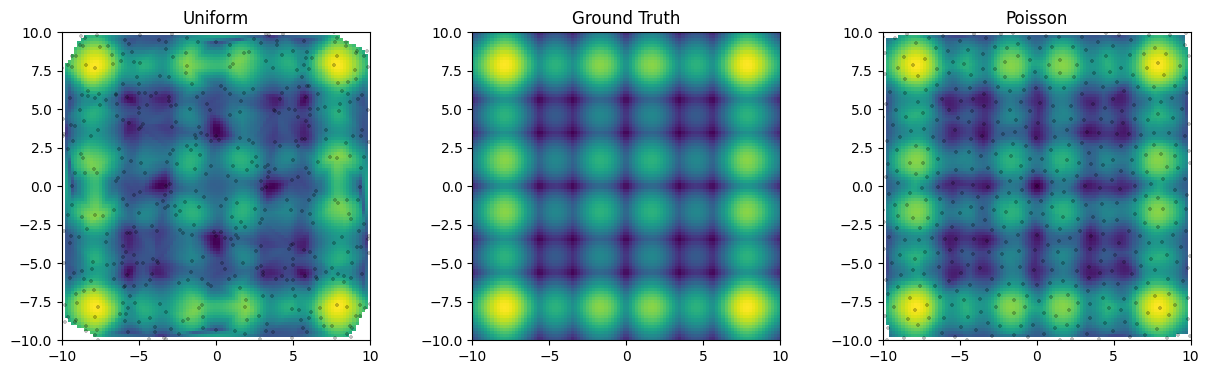

Single Instance


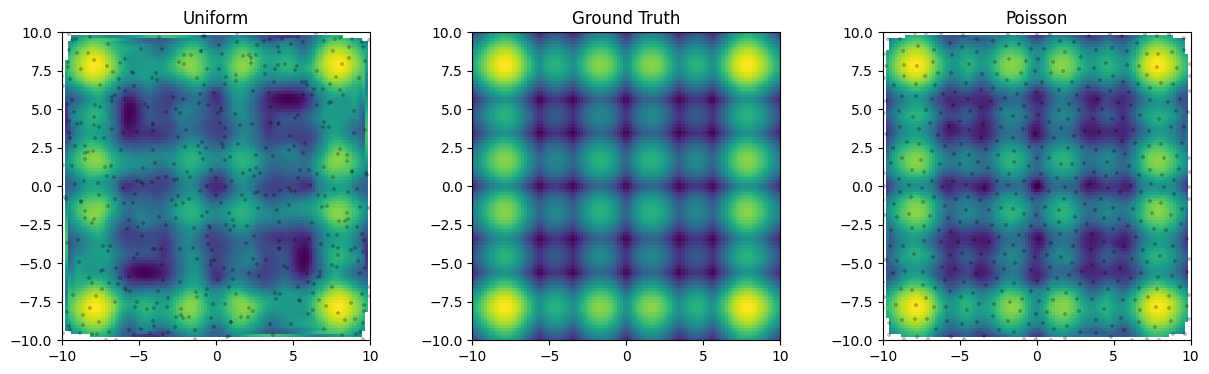

Single Instance


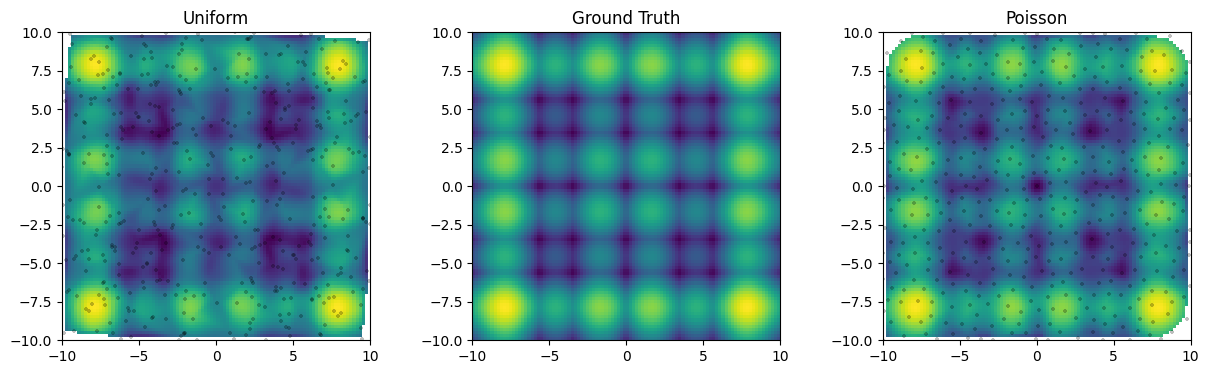

Single Instance


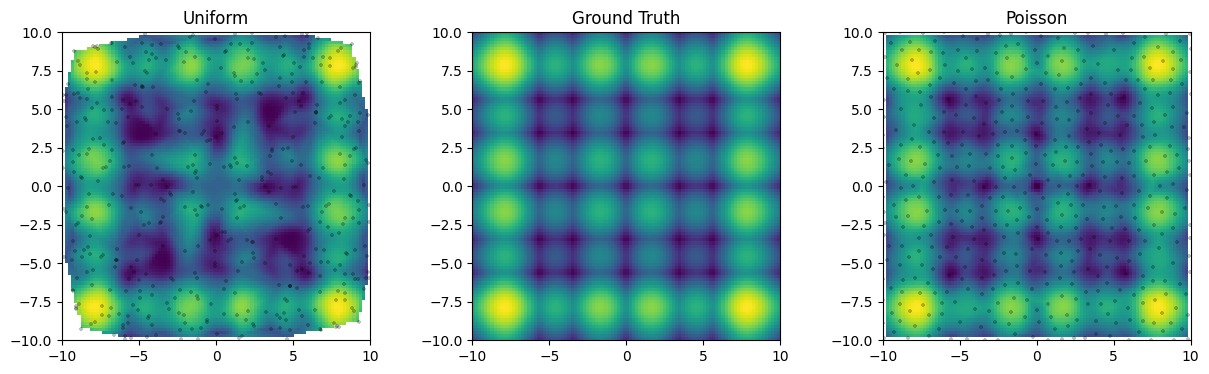

Single Instance


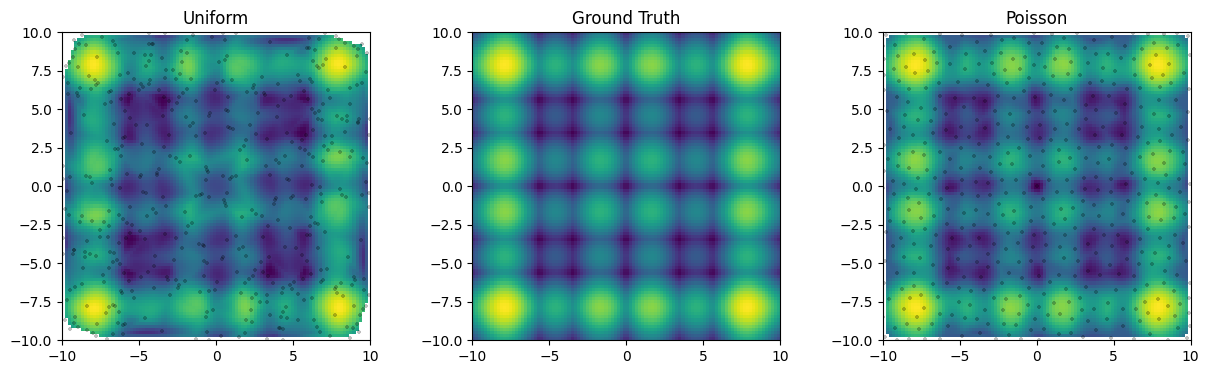

Single Instance


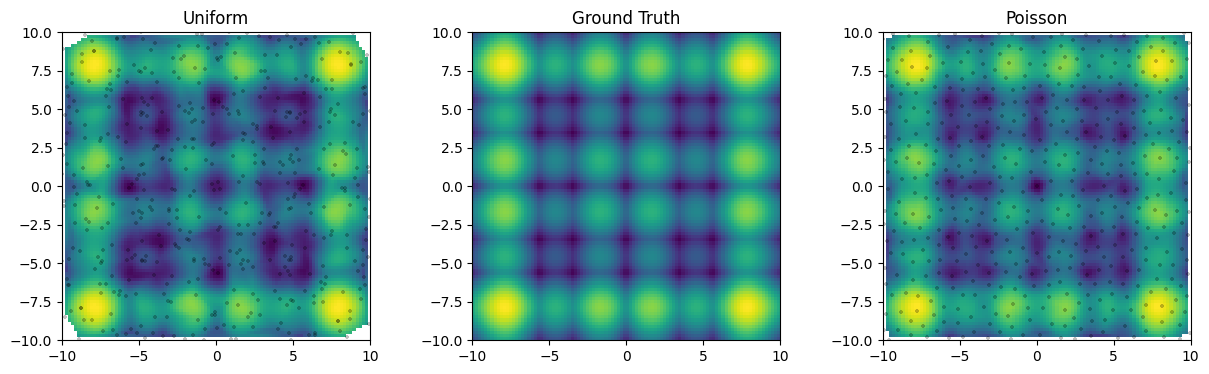

Single Instance


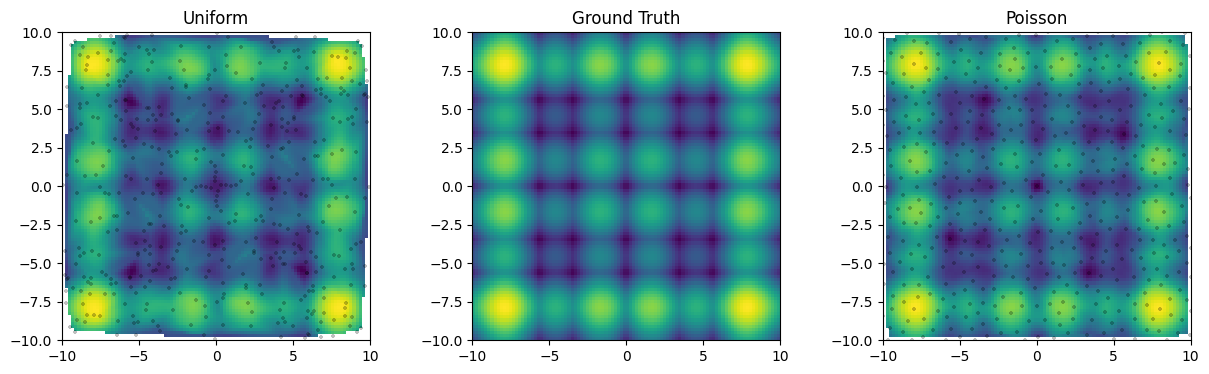

Single Instance


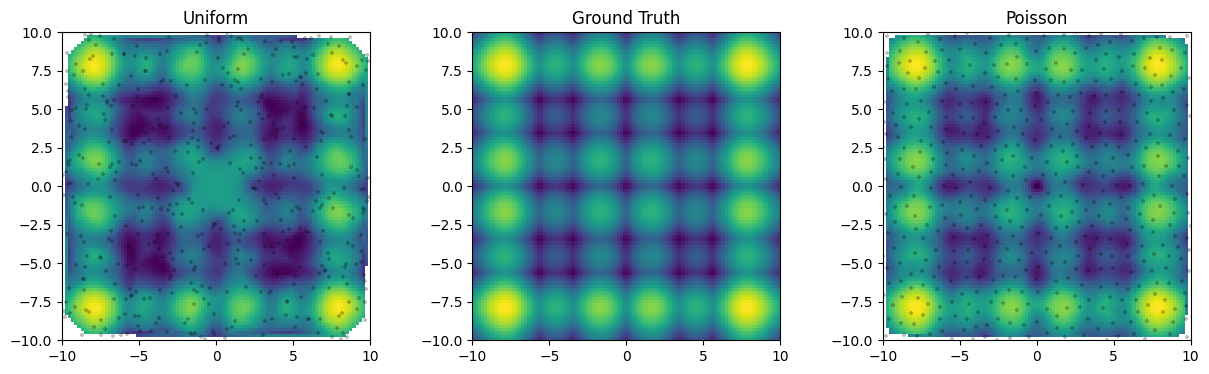

Single Instance


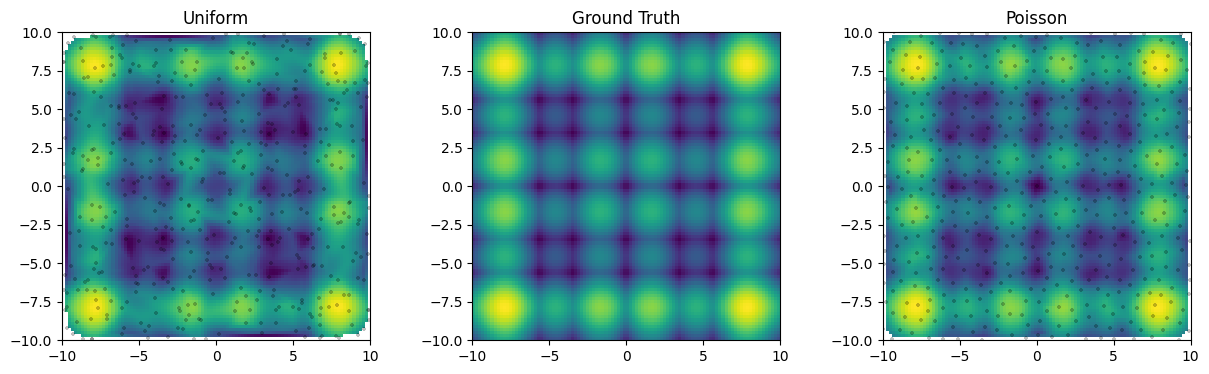

Single Instance


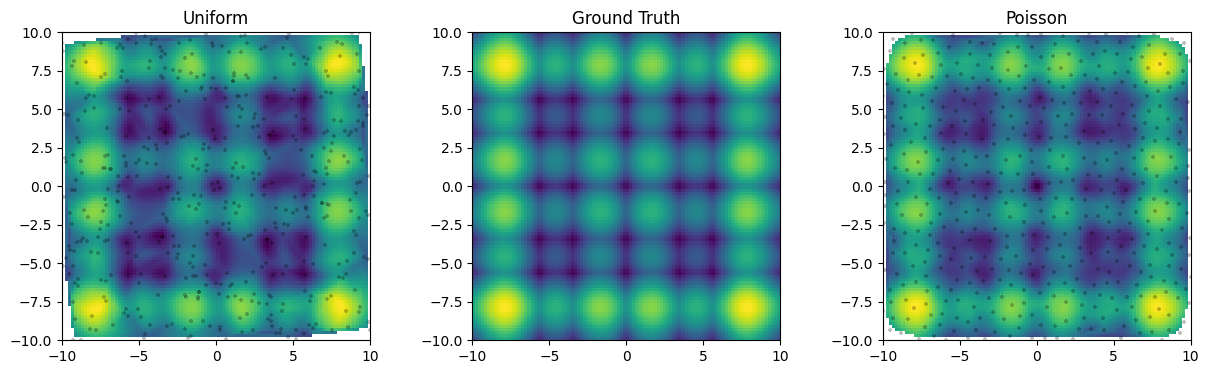

Single Instance


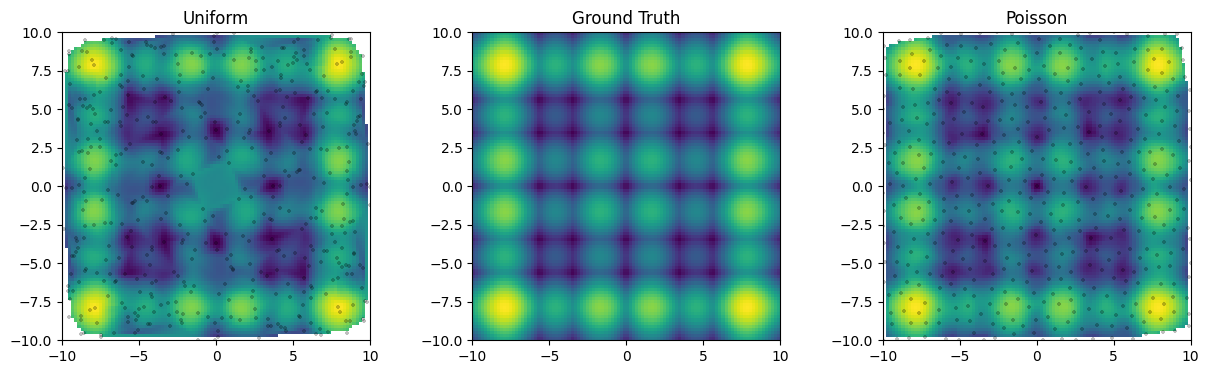

Single Instance


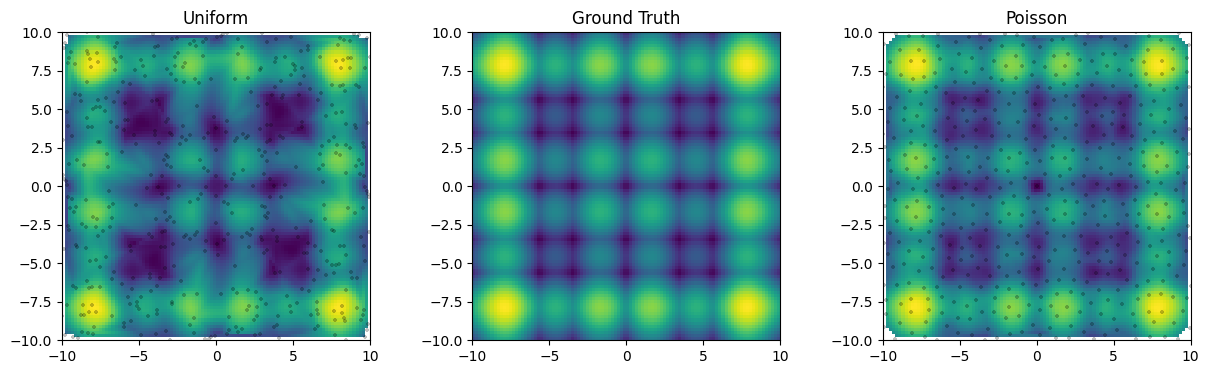

Single Instance


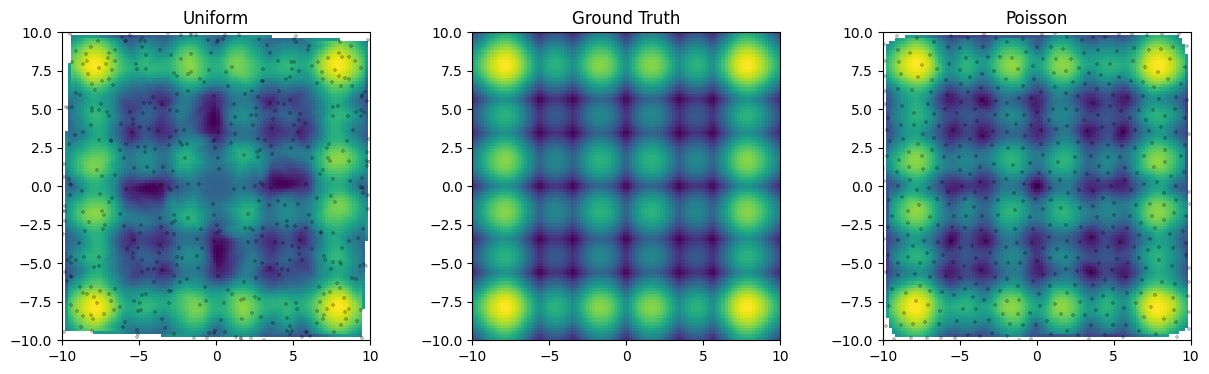

Single Instance


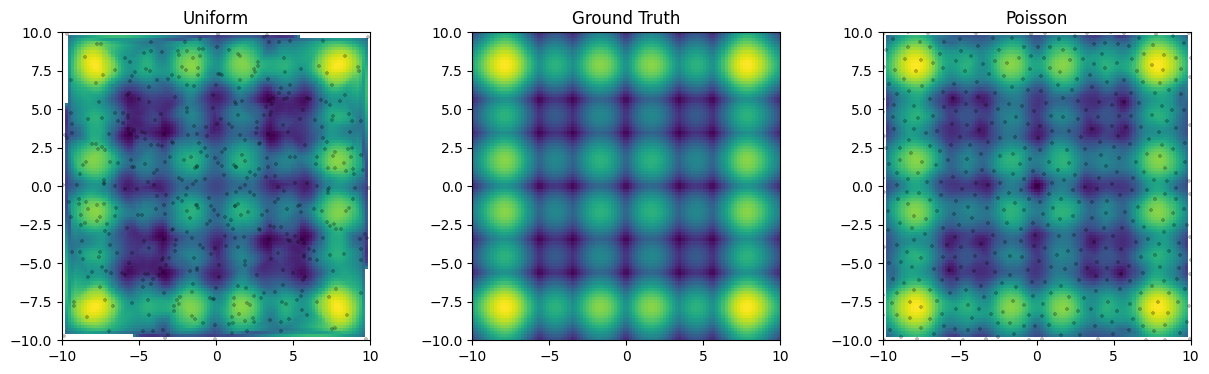

Single Instance


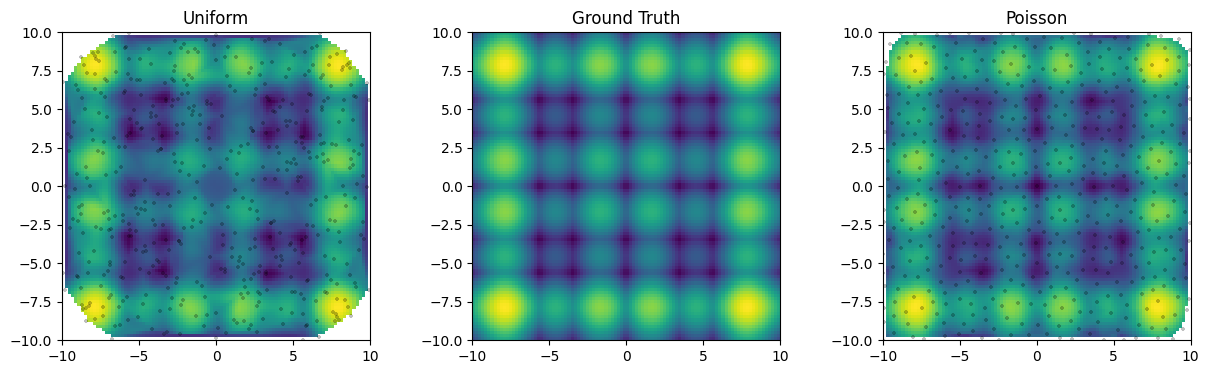

Single Instance


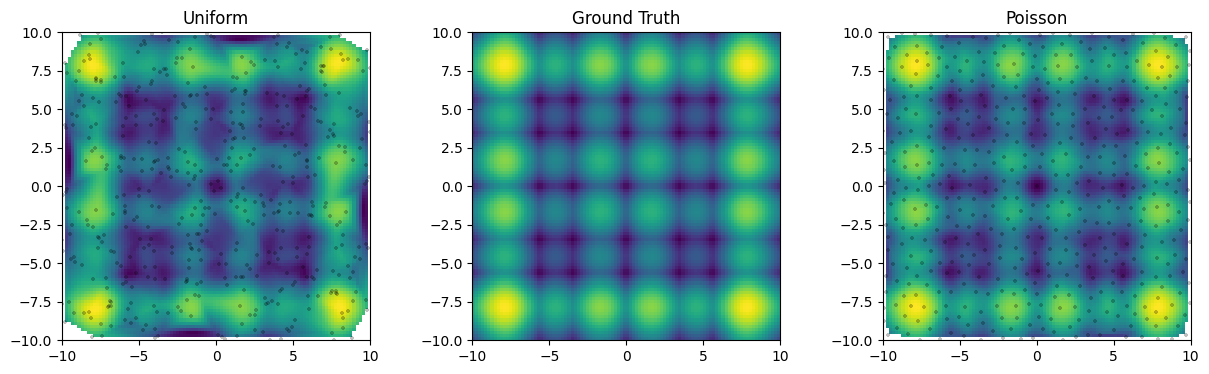

Single Instance


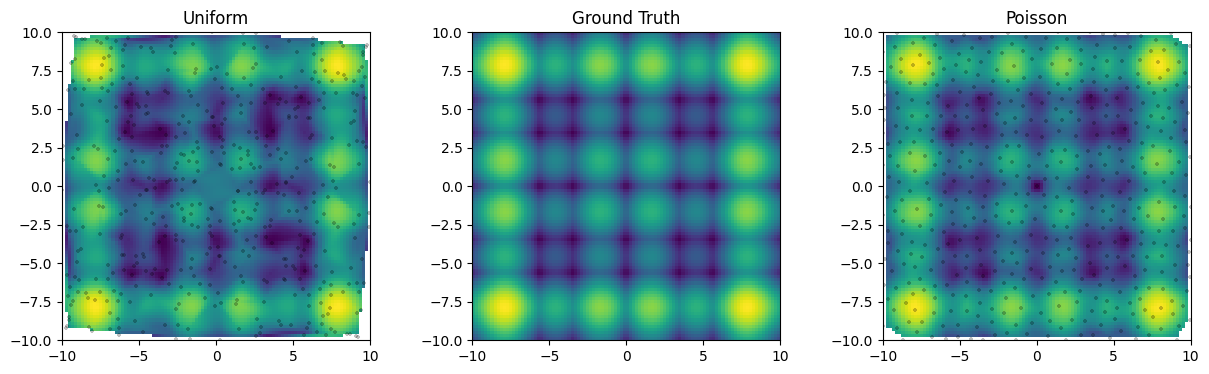

Single Instance


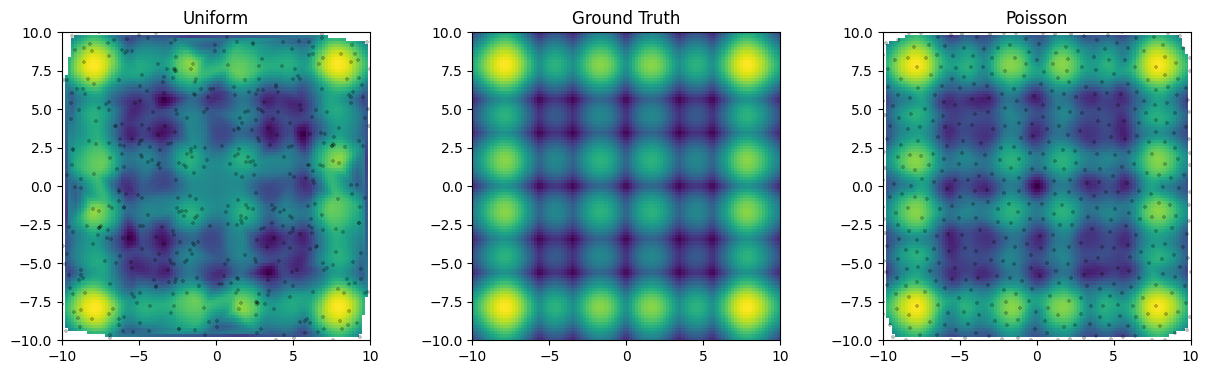

Single Instance


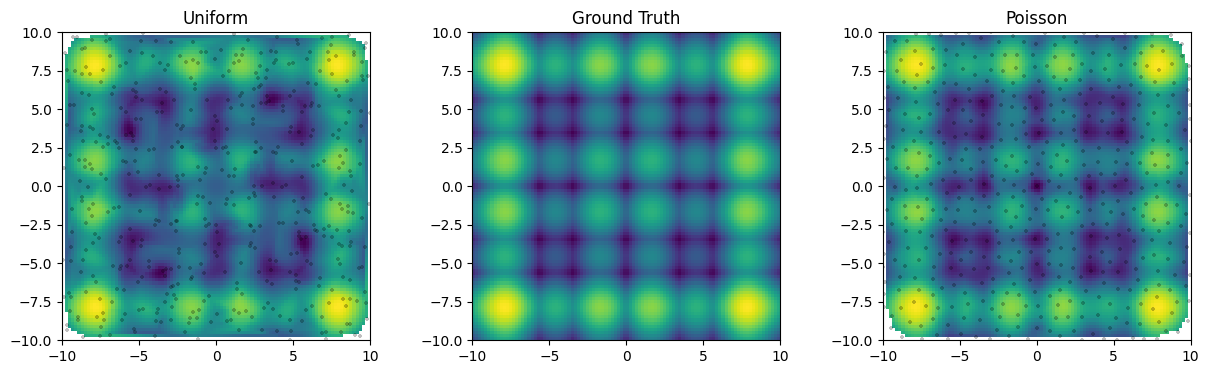

Single Instance


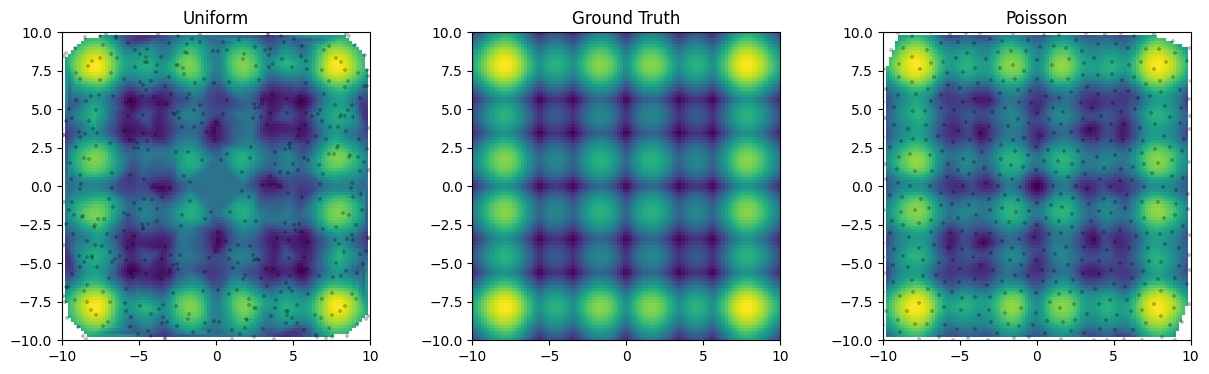

Single Instance


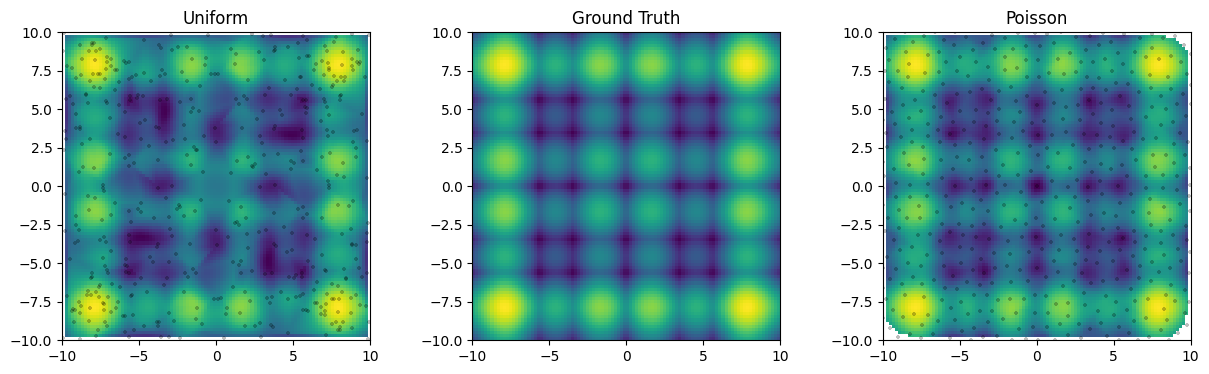

Single Instance


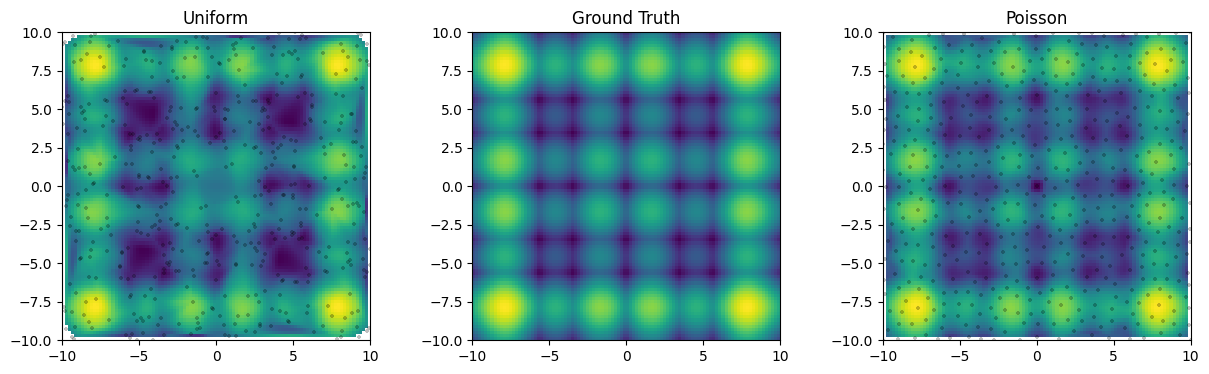

Single Instance


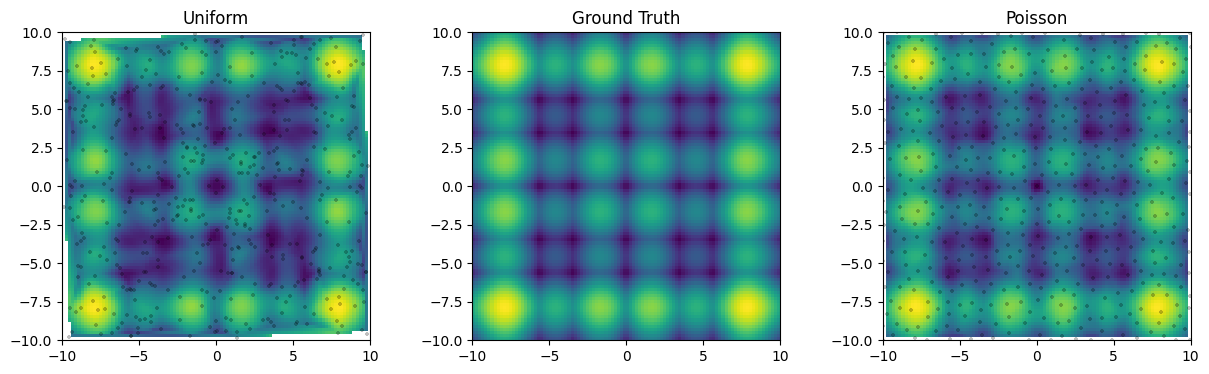

Single Instance


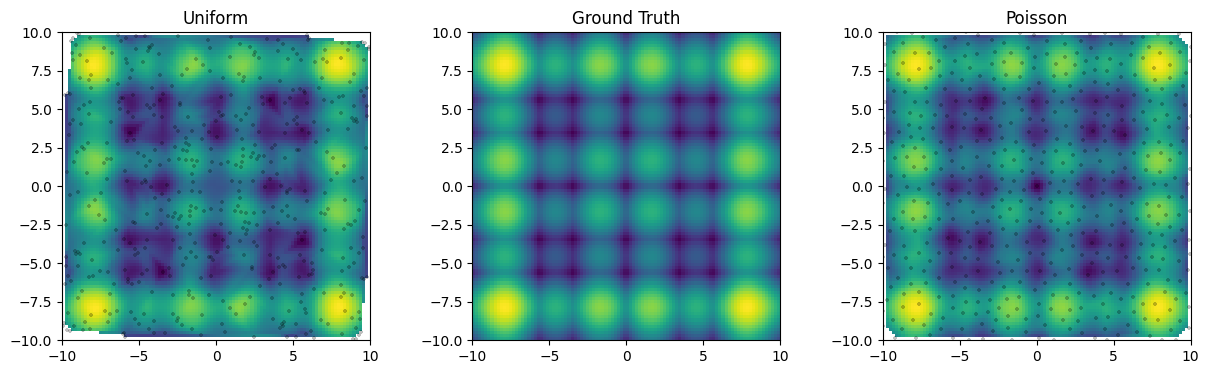

F1 0.7307044282049815 0.6509944549404995 489.0



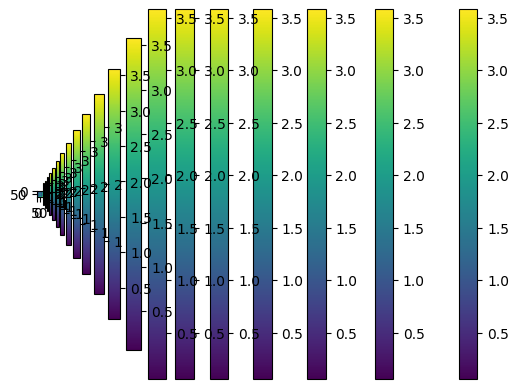

In [13]:
plt.close()


for level in np.unique(xyls[0][1]): 
    
    collected_best_Hs = []
    collected_best_Us = []
    collected_best_GTs = []
    
    f1_u = []
    f1_h = []
    
    N_points = []
    
    for trial in range(len(xyls)):       
        # select level
        xy = xyls[trial][0]
        levels = xyls[trial][1]
        
        sel = levels <= level
        # select poisson points
        xy_poisson = xy[sel]
        
        N_points.append( len(xy_poisson) )
        # build uniform random points
        OO = int((len(xy_poisson)-1)/4)
        
        xy_uniform = np.random.uniform(lower, upper, (OO,2))
        tmp = []
        for tt in xy_uniform:
            a = rotate(tt)
            b = rotate(a)
            c = rotate(b)
            tmp.append(tt)
            tmp.append(a)
            tmp.append(b)
            tmp.append(c)
        xy_uniform = np.array(tmp)

        # compute functions
        f_hiposa = []
        f_uniform = []
        for x_hiposa in xy_poisson:
            f_hiposa.append( f(x_hiposa) )
        for x_uniform in xy_uniform:
            f_uniform.append( f(x_uniform) )            
            
        f_hiposa = np.array(f_hiposa)
        f_uniform = np.array(f_uniform)
        
        # interpolate
        grid_hiposa = griddata(xy_poisson, f_hiposa, (grid_x, grid_y), method='cubic')
        grid_uniform = griddata(xy_uniform, f_uniform, (grid_x, grid_y), method='cubic')
        
        #truncated_grid_uniform = grid_uniform[10:-10,10:-10]
        #truncated_f_gt = f_gt[10:-10,10:-10]
        #truncated_grid_hiposa = grid_hiposa[10:-10,10:-10]
        cc_H = compute_masked_similarity(grid_hiposa, f_gt, percentile=1, method='pearson')
        cc_U = compute_masked_similarity(grid_uniform, f_gt, percentile=1, method='pearson')        
        #print(cc_H['macro_f1'], cc_U['macro_f1'], cc_H['macro_f1'] > cc_U['macro_f1'])
        f1_u.append(cc_U['macro_f1'])
        f1_h.append(cc_H['macro_f1'])
        plt.imshow(f_gt)
        plt.colorbar()
        #visualize_mask_similarity(grid_hiposa, f_gt, percentile=1, method='f1', figsize=(12, 10))   
        #visualize_mask_similarity(grid_uniform, f_gt, percentile=1, method='f1', figsize=(12, 10))      
        if trial< 30:    
            plt.close()        
            print("Single Instance")
            fig,axs = plt.subplots(1,3, figsize=(15,4))
            axs[0].imshow(grid_uniform, origin='lower', extent=(lower,upper,lower,upper))
            axs[0].scatter(xy_uniform[:,1], xy_uniform[:,0], marker="+", c='black', s=8, alpha=0.25)
            axs[0].set_title("Uniform")

            axs[1].imshow(f_gt, origin='lower',extent=(lower,upper,lower,upper))        
            axs[1].set_title("Ground Truth")

            #axs[2].scatter(xy_poisson[:,1], xy_poisson[:,0], c='orange', s=4)
            axs[2].imshow(grid_hiposa, origin='lower', extent=(lower,upper,lower,upper))             
            axs[2].scatter(xy_poisson[:,1], xy_poisson[:,0], marker="+", c='black', s=8, alpha=0.25) 
            axs[2].set_title("Poisson")
            plt.show()
            

    
  
        

    print( "F1", np.mean(f1_h), np.mean(f1_u), np.median(np.array(N_points)))
    print()
    print(80*"=")